In [1]:
import numpy as np

from keras.layers import Dense, Input, Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose

from keras.models import Model
from keras import backend as K

from keras.datasets import mnist

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


# Denoising autoencoder with Keras

## Load, examine & transform the data

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [0]:
# Reshape to add a color channel 
X_train = X_train.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])

In [0]:
# Get image size 
img_size = X_train.shape[1]

In [0]:
# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

* ### Get noisy images

In [0]:
# Generate train noise
noise = np.random.normal(loc   = .5, 
                         scale = .5, 
                         size  = X_train.shape)

In [0]:
X_train_noisy = X_train + noise

In [0]:
# Generate test noise
noise_2 = np.random.normal(loc   = .5, 
                           scale = .5, 
                           size  = X_test.shape)

In [0]:
X_test_noisy = X_test + noise_2

In [0]:
# Clip the values to 0 - 1 range
X_train_noisy = np.clip(X_train_noisy, 0, 1)
X_test_noisy  = np.clip(X_test_noisy, 0, 1)

## Define network params

In [0]:
input_shape = (img_size, img_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [32, 64]

## Build the model

* ### Encoder

In [13]:
inputs = Input(shape = input_shape, 
               name  = 'encoder_input')

x = inputs

W0621 10:53:55.084398 140341382162304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [14]:
# Build a stack of Conv2D layers

for filters in layer_filters:
    x = Conv2D(filters     = filters, 
               kernel_size = kernel_size, 
               strides     = 2, 
               activation  = 'relu',
               padding     = 'same')(x)

W0621 10:54:13.105423 140341382162304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 10:54:13.110241 140341382162304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
# Get encoder's output shape
enc_out_shape = K.int_shape(x)

In [16]:
enc_out_shape

(None, 7, 7, 64)

In [0]:
# Build the latent vector

x = Flatten()(x)
latent = Dense(latent_dim, 
               name = 'latent_vector')(x)

In [18]:
# Instantiate encoder model

encoder = Model(inputs, latent, 
                name = 'encoder')

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


* ### Decoder

In [0]:
decoder_inputs = Input(shape = (latent_dim,),
                       name  = 'decoder_input')

In [0]:
x = Dense(enc_out_shape[1] * enc_out_shape[2] * enc_out_shape[3])(decoder_inputs)

In [0]:
# Reshape input
x = Reshape((enc_out_shape[1], enc_out_shape[2], enc_out_shape[3]))(x)

In [0]:
# Build a stack of Conv2DTransp.

for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters     = filters, 
                        kernel_size = kernel_size,
                        strides     = 2,
                        activation  = 'relu',
                        padding     = 'same')(x)

In [0]:
# Reconstruct the denoised input
outputs = Conv2DTranspose(filters     = 1,
                          kernel_size = kernel_size,
                          padding     = 'same',
                          activation  = 'sigmoid',
                          name        = 'decoder_output')(x)

In [0]:
# Instantiate decoder model
decoder = Model(decoder_inputs, outputs, 
                name = 'decoder')

In [25]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_________________________________________________________________


* ### Autoencoder

In [0]:
autoencoder = Model(inputs, decoder(encoder(inputs)),
                    name = 'autoencoder')

In [27]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
autoencoder.compile(loss      = 'mse',
                    optimizer = 'adam')

W0621 10:54:45.490353 140341382162304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [29]:
# Training 
autoencoder.fit(X_train_noisy, X_train,
                validation_data = (X_test_noisy, X_test),
                epochs          = 2, 
                batch_size      = batch_size)

W0621 10:54:57.078041 140341382162304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0621 10:54:57.254924 140341382162304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 19s 311us/step - loss: 0.0376 - val_loss: 0.0203
Epoch 2/2
60000/60000 [==============================] - 12s 197us/step - loss: 0.0193 - val_loss: 0.0178


In [0]:
pred = autoencoder.predict(X_test_noisy[3:6])

Let's see how it works...

This is the original image:


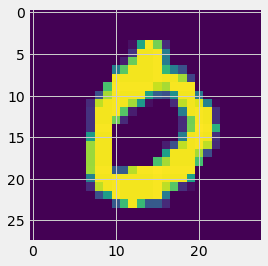



This is the noisy image:


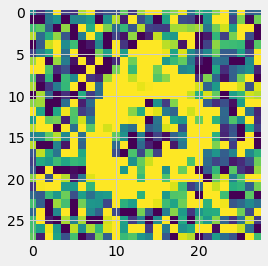



This is the de-noised image:


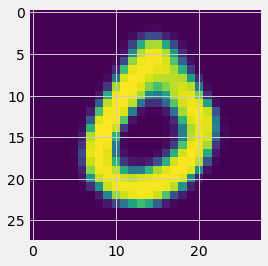

In [43]:
# Compare images
print("Let's see how it works...\n")
print("This is the original image:")
plt.imshow(X_test[3].squeeze())
plt.show()
print("\n\nThis is the noisy image:")
plt.imshow(X_test_noisy[3].squeeze())
plt.show()
print("\n\nThis is the de-noised image:")
plt.imshow(pred[0].squeeze())
plt.show()

In [0]:
# Sexy! :D
# PS: Note - it took only two epochs!

Let's see how it works...

This is the original image:


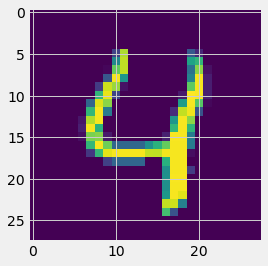



This is the noisy image:


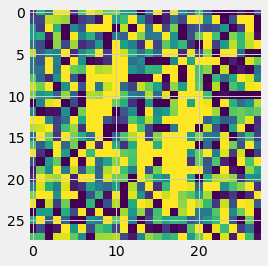



This is the de-noised image:


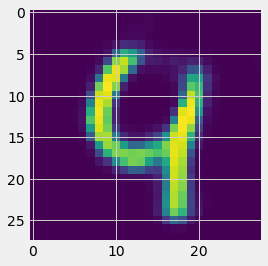

In [44]:
print("Let's see how it works...\n")
print("This is the original image:")
plt.imshow(X_test[4].squeeze())
plt.show()
print("\n\nThis is the noisy image:")
plt.imshow(X_test_noisy[4].squeeze())
plt.show()
print("\n\nThis is the de-noised image:")
plt.imshow(pred[1].squeeze())
plt.show()

Let's see how it works...

This is the original image:


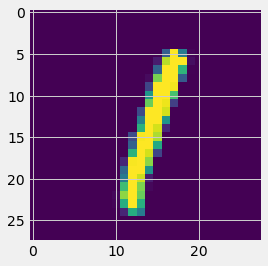



This is the noisy image:


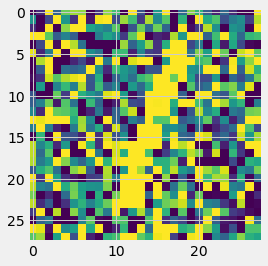



This is the de-noised image:


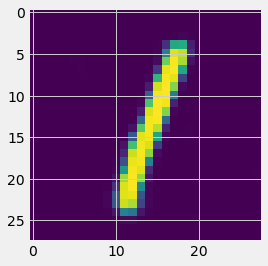

In [47]:
print("Let's see how it works...\n")
print("This is the original image:")
plt.imshow(X_test[5].squeeze())
plt.show()
print("\n\nThis is the noisy image:")
plt.imshow(X_test_noisy[5].squeeze())
plt.show()
print("\n\nThis is the de-noised image:")
plt.imshow(pred[2].squeeze())
plt.show()